# Basic CNN Model Evaluation


The trained baseline and dropout basic CNN models are evaluated by doing inference on the test split of cross-datasets. To evaluate the application of Monte Carlo Dropout technique, each dropout model also does the inference with a set of Monte Carlo samples defined as 50, 100, and 150. Each model's performance is interpreted by its ROC curve and AUC values.


In [1]:
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix
from matplotlib import pyplot as plt
from IPython.display import display
import tensorflow as tf
import pandas as pd
import numpy as np
import time
import os

%matplotlib inline

## Define Dataset Directory


In [2]:
CDF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/Celeb-DF-v2/Test"
DF_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DeeperForensics-1.0/Test"
DFDC_DATASET_DIR = "/kaggle/input/deepfake-detection-datasets/DFDC/Test"

## Define Trained Models Path


In [3]:
CNN_MODEL_DIR = "/kaggle/input/cnn-model-training"

In [4]:
baseline_cnn_cdf_model_path = os.path.join(
    CNN_MODEL_DIR, "baseline_cnn_cdf_model.keras"
)
baseline_cnn_df_model_path = os.path.join(CNN_MODEL_DIR, "baseline_cnn_df_model.keras")
baseline_cnn_dfdc_model_path = os.path.join(
    CNN_MODEL_DIR, "baseline_cnn_dfdc_model.keras"
)

In [5]:
dropout_cnn_cdf_model_path = os.path.join(CNN_MODEL_DIR, "dropout_cnn_cdf_model.keras")
dropout_cnn_df_model_path = os.path.join(CNN_MODEL_DIR, "dropout_cnn_df_model.keras")
dropout_cnn_dfdc_model_path = os.path.join(
    CNN_MODEL_DIR, "dropout_cnn_dfdc_model.keras"
)

## Load the Trained Models


In [6]:
baseline_cnn_cdf_model = tf.keras.models.load_model(baseline_cnn_cdf_model_path)
baseline_cnn_df_model = tf.keras.models.load_model(baseline_cnn_df_model_path)
baseline_cnn_dfdc_model = tf.keras.models.load_model(baseline_cnn_dfdc_model_path)

In [7]:
dropout_cnn_cdf_model = tf.keras.models.load_model(dropout_cnn_cdf_model_path)
dropout_cnn_df_model = tf.keras.models.load_model(dropout_cnn_df_model_path)
dropout_cnn_dfdc_model = tf.keras.models.load_model(dropout_cnn_dfdc_model_path)

## File Video Id Extraction Function


In [8]:
def extract_file_id(filepath):
    return filepath.split("-")[0]

## Image Preprocessing Function


In [9]:
def preprocess_image(filepath):
    image = load_img(filepath, target_size=(128, 128))
    image = img_to_array(image)
    image /= 255
    return image

## Get Dataset Metadata


In [10]:
def group_preprocessed_frames_by_file_id(dataset_dir, dataset_name):
    label_dirs = [
        os.path.join(dataset_dir, label) for label in ["Deepfake", "Original"]
    ]

    metadata = {"name": dataset_name, "videos": {}}

    for label_dir in label_dirs:
        label = 0 if label_dir.split("/")[-1] == "Deepfake" else 1
        for filename in os.listdir(label_dir):
            file_id = extract_file_id(filename)
            filepath = os.path.join(label_dir, filename)
            preprocessed_image = preprocess_image(filepath)

            if metadata["videos"].get(file_id) == None:
                metadata["videos"][file_id] = {"label": label, "data": []}

            metadata["videos"][file_id]["data"].append(preprocessed_image)

    return metadata

In [11]:
cdf_metadata = group_preprocessed_frames_by_file_id(
    CDF_DATASET_DIR, dataset_name="Celeb-DF-v2"
)
df_metadata = group_preprocessed_frames_by_file_id(
    DF_DATASET_DIR, dataset_name="DeeperForensics-1.0"
)
dfdc_metadata = group_preprocessed_frames_by_file_id(
    DFDC_DATASET_DIR, dataset_name="DFDC"
)

datasets = [cdf_metadata, df_metadata, dfdc_metadata]

## Evaluate Each Model in Cross Dataset


### Function to Get FPR, TPR, and AUC Metric Value of a Model's Prediction


In [12]:
def get_model_prediction_metrics_on_dataset(
    model,
    dataset_videos,
    mc_dropout=False,
    mc_sample_size=100,
):
    predictions = {"data_id": [], "y_true": [], "y_pred_score": []}

    for id in dataset_videos.keys():
        label = dataset_videos[id].get("label")
        predictions["y_true"].append(label)
        predictions["data_id"].append(id)

        images_data = np.array(dataset_videos[id].get("data"))
        if mc_dropout:
            mc_prediction_scores = np.stack(
                [model(images_data, training=True) for _ in range(mc_sample_size)]
            )
            frame_prediction_scores = np.mean(mc_prediction_scores, axis=0)
        else:
            frame_prediction_scores = model(images_data, training=False)

        video_prediction_score = np.mean(frame_prediction_scores)
        predictions["y_pred_score"].append(video_prediction_score)

    fpr, tpr, _ = roc_curve(
        predictions["y_true"],
        predictions["y_pred_score"],
        drop_intermediate=False,
    )
    roc_auc = auc(fpr, tpr)

    y_pred = (np.array(predictions["y_pred_score"]) > 0.5).astype(int)
    cm = confusion_matrix(predictions["y_true"], y_pred).ravel()

    return fpr, tpr, roc_auc, cm, predictions

### Model Evaluation Function


In [13]:
def evaluate_model_on_cross_datasets(
    model,
    datasets,
    mc_dropout=False,
    mc_sample_size=100,
    model_name="Model",
):
    cm_data = {
        "Dataset": [],
        "TN": [],
        "FP": [],
        "FN": [],
        "TP": [],
    }

    prediction_data = {"dataset": [], "data_id": [], "y_true": [], "y_pred_score": []}

    plot_colors = ["dodgerblue", "red", "forestgreen"]

    plt.plot([0, 1], [0, 1], color="lightsteelblue", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC Curve")

    for i, dataset in enumerate(datasets):
        start_time = time.time()
        dataset_name = dataset.get("name")
        print(f"Evaluating on {dataset_name}...")
        fpr, tpr, roc_auc, cm, predictions = get_model_prediction_metrics_on_dataset(
            model,
            dataset.get("videos"),
            mc_dropout,
            mc_sample_size,
        )
        print(f"=> Finished in {round(time.time() - start_time, 3)} seconds\n")

        plt.plot(
            fpr,
            tpr,
            color=plot_colors[i],
            label=f"{dataset_name} (AUC = {round(roc_auc, 3)})",
        )

        prediction_data["dataset"].extend(
            [dataset_name for _ in range(len(predictions.get("data_id")))]
        )
        prediction_data["data_id"].extend(predictions.get("data_id"))
        prediction_data["y_true"].extend(predictions.get("y_true"))
        prediction_data["y_pred_score"].extend(predictions.get("y_pred_score"))

        tn, fp, fn, tp = cm
        cm_data["Dataset"].append(dataset_name)
        cm_data["TN"].append(tn)
        cm_data["FP"].append(fp)
        cm_data["FN"].append(fn)
        cm_data["TP"].append(tp)

    plt.legend(loc="lower right")
    plt.show()

    cm_df = pd.DataFrame(cm_data)
    display(cm_df)

    prediction_data_df = pd.DataFrame(prediction_data)
    prediction_data_filename = (
        model_name.lower().replace(" ", "-") + "-predictions" + ".csv"
    )
    prediction_data_df.to_csv(prediction_data_filename, index=False)

### Models Evaluation


In [14]:
x = baseline_cnn_cdf_model(np.array(datasets[0]["videos"]["id25_id24_0002"]["data"]))
del x

#### Trained on Celeb-DF-v2


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 3.008 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 2.979 seconds

Evaluating on DFDC...
=> Finished in 2.972 seconds



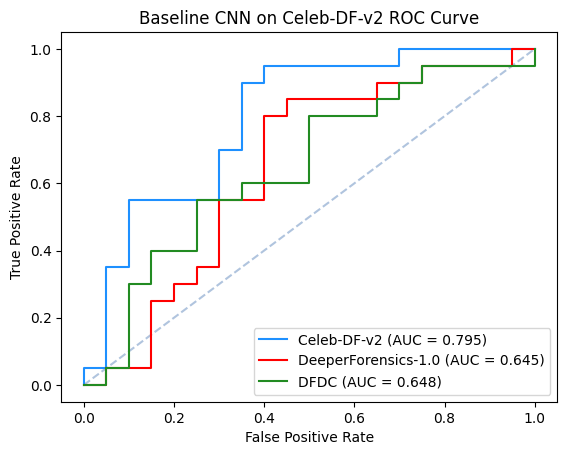

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,13,7,6,14
1,DeeperForensics-1.0,5,15,1,19
2,DFDC,10,10,7,13


CPU times: user 8.29 s, sys: 1.23 s, total: 9.52 s
Wall time: 9.27 s


In [15]:
%%time
evaluate_model_on_cross_datasets(
    baseline_cnn_cdf_model,
    datasets,
    model_name="Baseline CNN on Celeb-DF-v2"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 2.649 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 2.599 seconds

Evaluating on DFDC...
=> Finished in 2.609 seconds



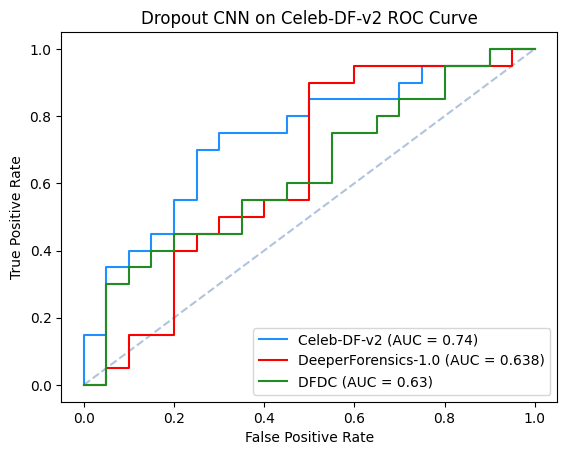

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,16,4,9,11
1,DeeperForensics-1.0,8,12,2,18
2,DFDC,11,9,9,11


CPU times: user 8.09 s, sys: 232 ms, total: 8.32 s
Wall time: 8.05 s


In [16]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_cdf_model,
    datasets,
    model_name="Dropout CNN on Celeb-DF-v2"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 130.51 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 129.614 seconds

Evaluating on DFDC...
=> Finished in 129.601 seconds



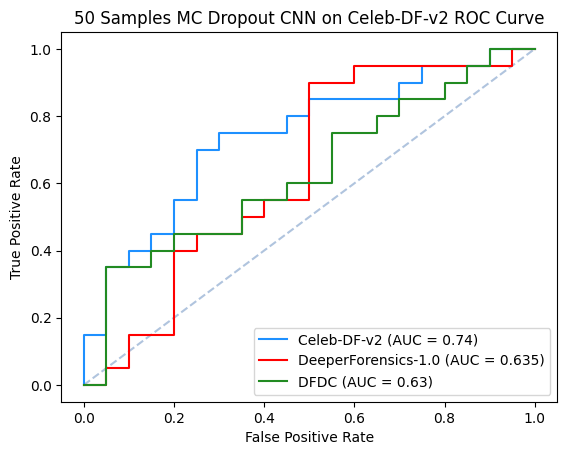

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,16,4,9,11
1,DeeperForensics-1.0,8,12,2,18
2,DFDC,11,9,9,11


CPU times: user 3min 12s, sys: 4.07 s, total: 3min 16s
Wall time: 6min 29s


In [17]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_cdf_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout CNN on Celeb-DF-v2"
)

Evaluating on Celeb-DF-v2...
=> Finished in 267.282 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 267.043 seconds

Evaluating on DFDC...
=> Finished in 267.13 seconds



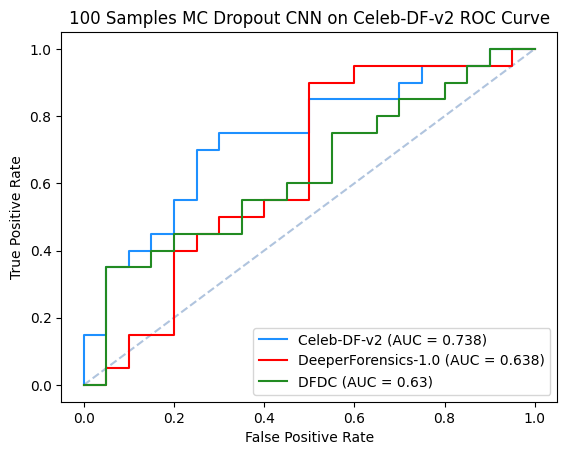

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,16,4,9,11
1,DeeperForensics-1.0,8,12,2,18
2,DFDC,11,9,9,11


CPU times: user 6min 46s, sys: 6.59 s, total: 6min 53s
Wall time: 13min 21s


In [18]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_cdf_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=100,
    model_name="100 Samples MC Dropout CNN on Celeb-DF-v2"

)

Evaluating on Celeb-DF-v2...
=> Finished in 403.627 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 404.953 seconds

Evaluating on DFDC...
=> Finished in 404.945 seconds



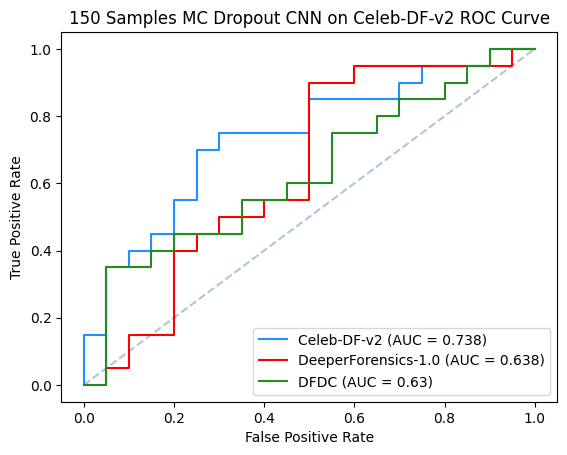

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,16,4,9,11
1,DeeperForensics-1.0,8,12,2,18
2,DFDC,11,9,9,11


CPU times: user 10min 23s, sys: 10 s, total: 10min 33s
Wall time: 20min 13s


In [19]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_cdf_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=150,
    model_name="150 Samples MC Dropout CNN on Celeb-DF-v2"

)

#### Trained on DeeperForensics-1.0


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 2.621 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 2.616 seconds

Evaluating on DFDC...
=> Finished in 2.626 seconds



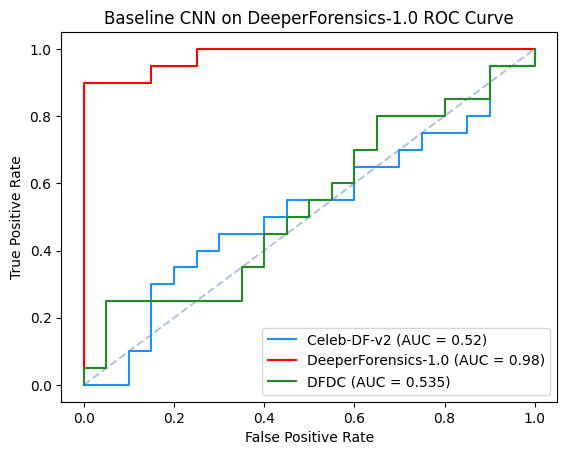

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,4,16,5,15
1,DeeperForensics-1.0,19,1,2,18
2,DFDC,8,12,7,13


CPU times: user 8.14 s, sys: 181 ms, total: 8.32 s
Wall time: 8.05 s


In [20]:
%%time
evaluate_model_on_cross_datasets(
    baseline_cnn_df_model,
    datasets,
    model_name="Baseline CNN on DeeperForensics-1.0"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 2.707 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 2.688 seconds

Evaluating on DFDC...
=> Finished in 2.724 seconds



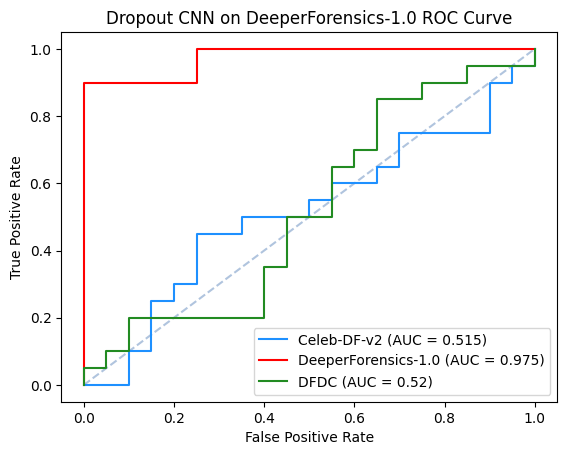

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,3,17,5,15
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,8,12,7,13


CPU times: user 8.45 s, sys: 194 ms, total: 8.65 s
Wall time: 8.38 s


In [21]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_df_model,
    datasets,
    model_name="Dropout CNN on DeeperForensics-1.0"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 134.838 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 134.229 seconds

Evaluating on DFDC...
=> Finished in 134.869 seconds



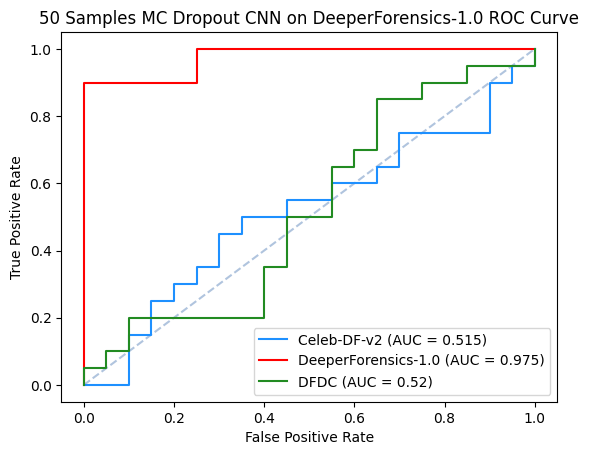

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,3,17,5,15
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,8,12,7,13


CPU times: user 3min 27s, sys: 3.52 s, total: 3min 30s
Wall time: 6min 44s


In [22]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_df_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout CNN on DeeperForensics-1.0"
)

Evaluating on Celeb-DF-v2...
=> Finished in 268.468 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 269.442 seconds

Evaluating on DFDC...
=> Finished in 269.001 seconds



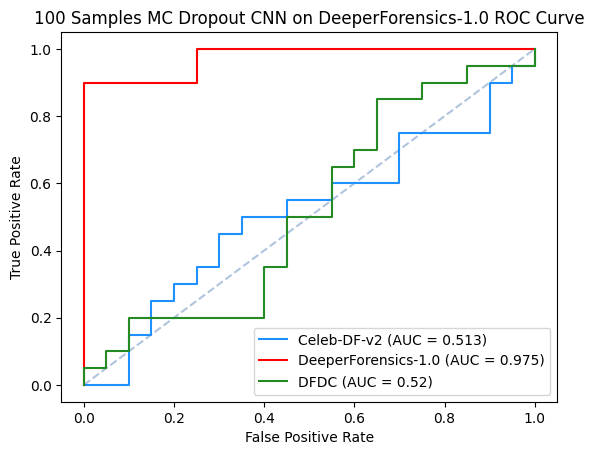

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,3,17,5,15
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,8,12,7,13


CPU times: user 6min 51s, sys: 6.73 s, total: 6min 58s
Wall time: 13min 27s


In [23]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_df_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=100,
    model_name="100 Samples MC Dropout CNN on DeeperForensics-1.0"
)

Evaluating on Celeb-DF-v2...
=> Finished in 390.98 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 390.358 seconds

Evaluating on DFDC...
=> Finished in 391.38 seconds



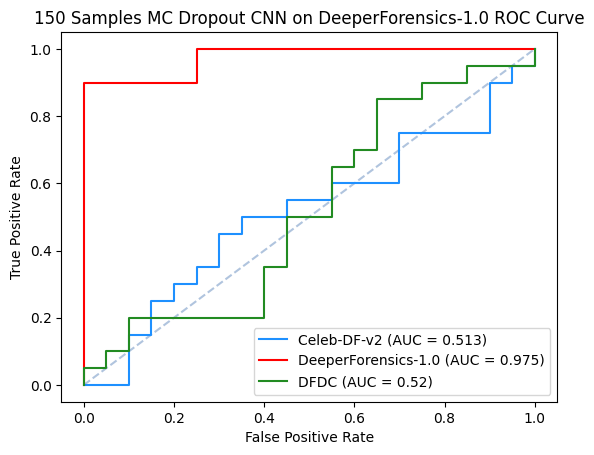

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,3,17,5,15
1,DeeperForensics-1.0,20,0,3,17
2,DFDC,8,12,7,13


CPU times: user 9min 38s, sys: 9.49 s, total: 9min 47s
Wall time: 19min 32s


In [24]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_df_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=150,
    model_name="150 Samples MC Dropout CNN on DeeperForensics-1.0"
)

#### Trained on DFDC


##### Baseline Model


Evaluating on Celeb-DF-v2...
=> Finished in 2.667 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 2.672 seconds

Evaluating on DFDC...
=> Finished in 2.687 seconds



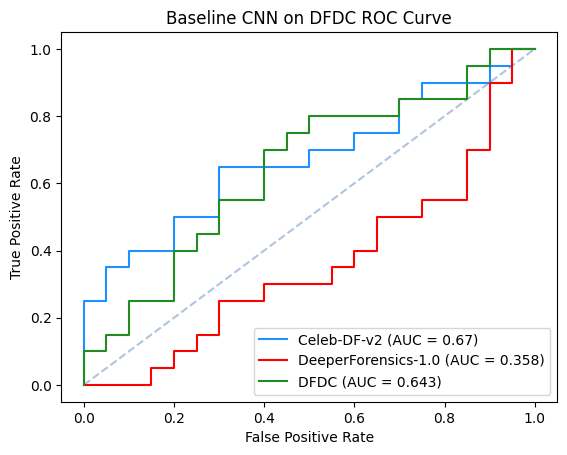

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,19,1,13,7
1,DeeperForensics-1.0,5,15,9,11
2,DFDC,16,4,12,8


CPU times: user 8.33 s, sys: 216 ms, total: 8.55 s
Wall time: 8.28 s


In [25]:
%%time
evaluate_model_on_cross_datasets(
    baseline_cnn_dfdc_model,
    datasets,
    model_name="Baseline CNN on DFDC"
)

##### Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 2.674 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 2.682 seconds

Evaluating on DFDC...
=> Finished in 2.7 seconds



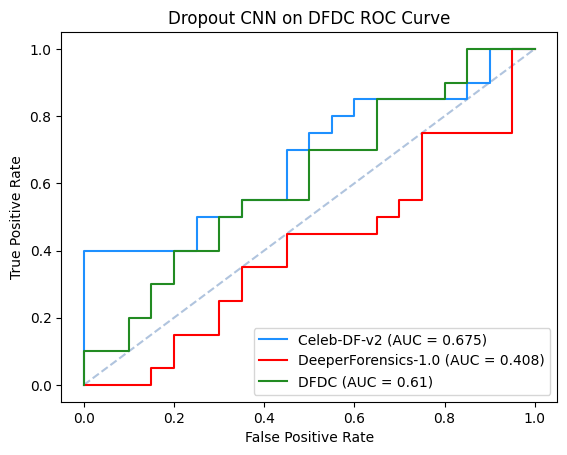

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,18,2
1,DeeperForensics-1.0,11,9,12,8
2,DFDC,17,3,16,4


CPU times: user 8.31 s, sys: 190 ms, total: 8.5 s
Wall time: 8.23 s


In [26]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_dfdc_model,
    datasets,
    model_name="Dropout CNN on DFDC"
)

##### Monte Carlo Dropout Model


Evaluating on Celeb-DF-v2...
=> Finished in 134.108 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 134.294 seconds

Evaluating on DFDC...
=> Finished in 134.003 seconds



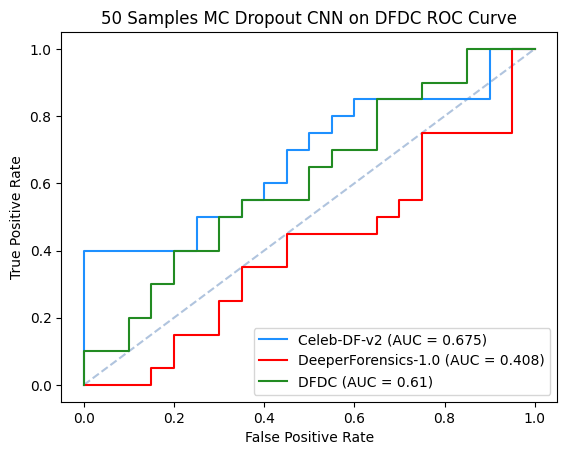

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,18,2
1,DeeperForensics-1.0,11,9,12,8
2,DFDC,17,3,16,4


CPU times: user 3min 24s, sys: 3.32 s, total: 3min 27s
Wall time: 6min 42s


In [27]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_dfdc_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=50,
    model_name="50 Samples MC Dropout CNN on DFDC"
)

Evaluating on Celeb-DF-v2...
=> Finished in 268.338 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 267.334 seconds

Evaluating on DFDC...
=> Finished in 267.354 seconds



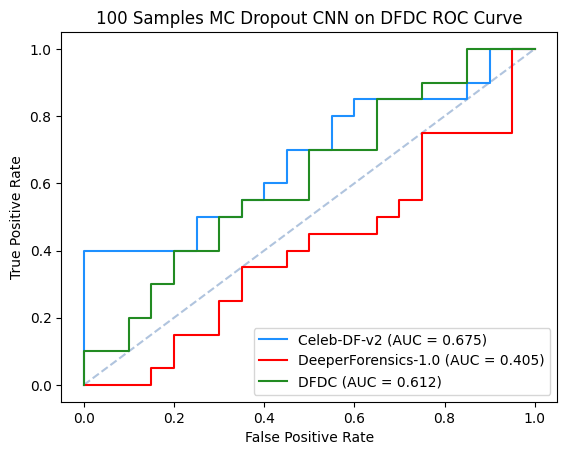

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,18,2
1,DeeperForensics-1.0,11,9,12,8
2,DFDC,17,3,16,4


CPU times: user 6min 46s, sys: 6.49 s, total: 6min 52s
Wall time: 13min 23s


In [28]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_dfdc_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=100,
    model_name="100 Samples MC Dropout CNN on DFDC"
)

Evaluating on Celeb-DF-v2...
=> Finished in 390.594 seconds

Evaluating on DeeperForensics-1.0...
=> Finished in 390.458 seconds

Evaluating on DFDC...
=> Finished in 392.0 seconds



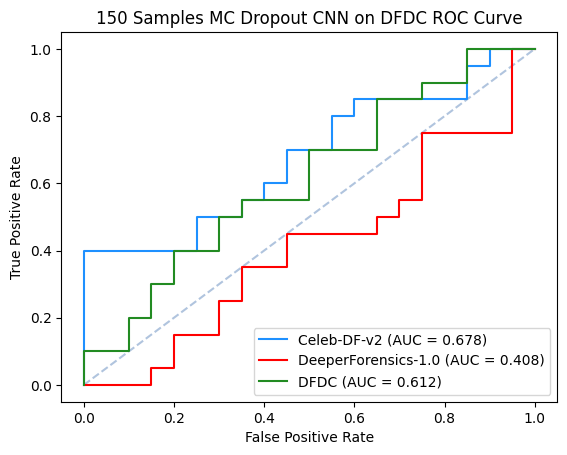

,Dataset,TN,FP,FN,TP
0,Celeb-DF-v2,20,0,18,2
1,DeeperForensics-1.0,11,9,12,8
2,DFDC,17,3,16,4


CPU times: user 9min 39s, sys: 9.38 s, total: 9min 49s
Wall time: 19min 33s


In [29]:
%%time
evaluate_model_on_cross_datasets(
    dropout_cnn_dfdc_model,
    datasets,
    mc_dropout=True,
    mc_sample_size=150,
    model_name="150 Samples MC Dropout CNN on DFDC"
)